In [1]:
# This is a set of scripts to explore a MVPA analysis with Smith and Wang
# Python 2
# First thing is importing the libraries
import nilearn
from nilearn import datasets,image,masking,signal,plotting,input_data
import numpy as np
import pandas as pd
import sklearn as skl
import os
import matplotlib.pyplot as plt
os.chdir('../')


/usr/local/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  after removing the cwd from sys.path.
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/utils/graph.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path  # noqa
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset impo

In [2]:
#Second thing is getting the data
# Gonna download 2 sets of masks that we may use
sub_cort_HO=datasets.fetch_atlas_harvard_oxford(
    'sub-prob-2mm')
pauli=datasets.fetch_atlas_pauli_2017()
#List of z_images
func_list=[]
label_list=[]
#List of labels
sublist=os.listdir('data')
for sub in sublist:
    print sub
    func_list.append('data/%s/%s_func.nii.gz'%(sub,sub))
    label_list.append(
        pd.read_csv('data/%s/%s_labels.csv'%(sub,sub)
                   ,sep='\t'))
    
for df in label_list:
    df['high_low']=df.apply(lambda row: np.greater(row[3],2.5),axis=1 )

sub-119
sub-118
sub-107
sub-113
sub-106
sub-112
sub-125
sub-123
sub-108
sub-111
sub-115
sub-117
sub-120
sub-116
sub-114
sub-109
sub-121
sub-122
sub-104
sub-110


Here we verify that everything is looking normal for one subject
sub-119
data/sub-119/sub-119_func.nii.gz


,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,3.0,0.0,a,1,True
1,1,2.0,1.0,1.0,0.0,a,1,False
2,2,3.0,1.0,2.0,0.0,a,1,False
3,3,4.0,1.0,2.0,0.0,a,1,False
4,4,5.0,1.0,2.0,0.0,a,1,False


 The areas in the pauli 2017 atlas are ['Pu', 'Ca', 'NAC', 'EXA', 'GPe', 'GPi', 'SNc', 'RN', 'SNr', 'PBP', 'VTA', 'VeP', 'HN', 'HTH', 'MN', 'STH']


/home/local/TU/tuj71575/.local/lib/python2.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


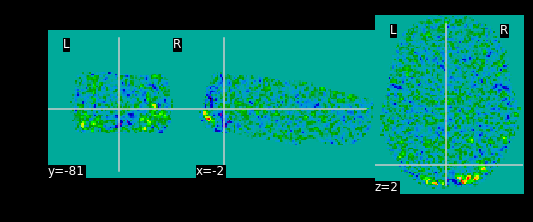

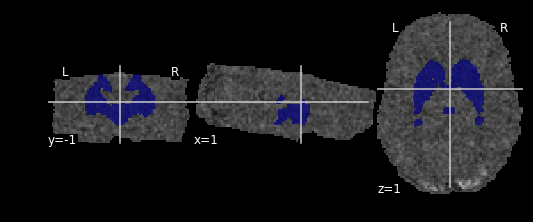

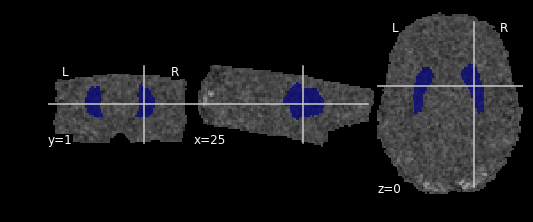

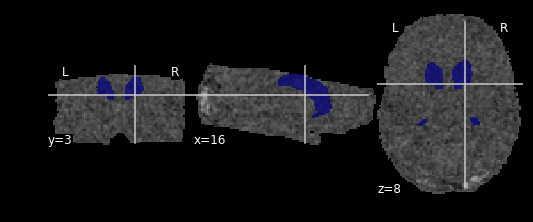

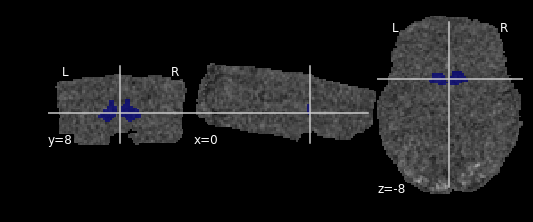

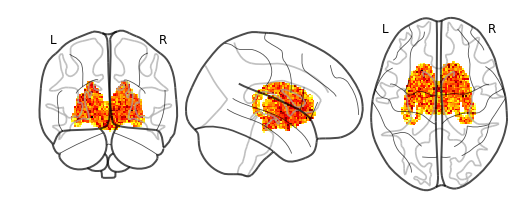

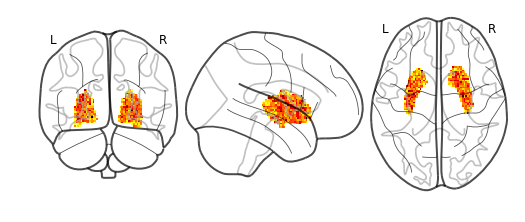

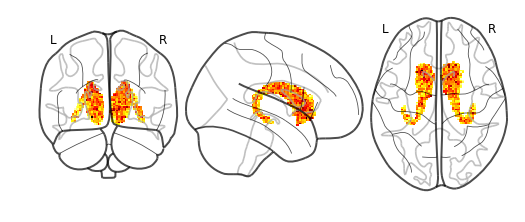

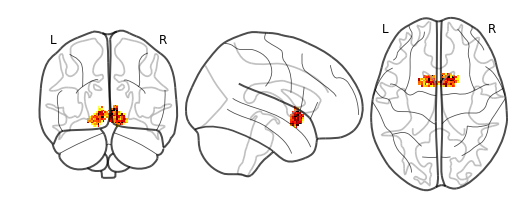

In [3]:
#Let's check out our data and masks
#the behavioral is hopefully easiest to verify
print("Here we verify that everything is looking normal for one subject")
print(sublist[0])
#we can check manually if we want that
#this is correct. It is
print(func_list[0])
display(label_list[0].head())
print(" The areas in the pauli 2017 atlas are %s"%(pauli.labels))
func=image.load_img(func_list[0])
mean_img=image.image.mean_img(func)
plotting.plot_epi(mean_img)
small_mask=masking.compute_background_mask(
    image.resample_to_img(pauli.maps,mean_img,interpolation='linear'))

res_put=masking.compute_background_mask(
    image.resample_to_img(image.index_img(pauli.maps,0),mean_img,interpolation='linear'))

res_caud=masking.compute_background_mask(
    image.resample_to_img(image.index_img(pauli.maps,1),mean_img,interpolation='linear'))

res_Nac=masking.compute_background_mask(
    image.resample_to_img(image.index_img(pauli.maps,2),mean_img,interpolation='linear'))

plotting.plot_roi(small_mask,mean_img)
plotting.plot_roi(res_put,mean_img)
plotting.plot_roi(res_caud,mean_img)
plotting.plot_roi(res_Nac,mean_img)

#make a few different maskers for full subcortex of interest and sub areas
full_pauli_masker=input_data.NiftiMasker(mask_img=small_mask, standardize=True)
Put_masker=input_data.NiftiMasker(mask_img=res_put,standardize=True)
                                            
Caud_masker=input_data.NiftiMasker(mask_img=res_caud,standardize=True)
                                   
NAc_masker=input_data.NiftiMasker(mask_img=res_Nac,standardize=True)

maskers=[full_pauli_masker,Put_masker,Caud_masker,NAc_masker]

#look at all the masked images they make
masked_img=full_pauli_masker.fit_transform(image.index_img(func,1))
Put_masked_img=Put_masker.fit_transform(image.index_img(func,1))
Caud_masked_img=Caud_masker.fit_transform(image.index_img(func,1))
NAc_masked_img=NAc_masker.fit_transform(image.index_img(func,1))

plotting.plot_glass_brain(image.image.mean_img(
        full_pauli_masker.inverse_transform(masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        Put_masker.inverse_transform(Put_masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        Caud_masker.inverse_transform(Caud_masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        NAc_masker.inverse_transform(NAc_masked_img)))
plt.show()

In [7]:
from nilearn.input_data import NiftiMasker
from sklearn import preprocessing
import pandas as pd
sub="sub-119"
from sklearn.svm import SVC
svc = SVC(kernel='linear',C=1)
cols=['sub','mask','train_desc','test_desc','acc','train_test']
my_data=pd.DataFrame(columns=['sub','mask','train_desc','test_desc','acc','train_test'])
for i,sub in enumerate(sublist):
    func=image.load_img(func_list[i])
    mean_img=image.image.mean_img(func)
    print sub,func_list[i]
    behavioral = pd.read_csv('data/%s/%s_labels.csv'%(sub,sub),sep='\t')
    func_filename = func_list[i]
    
    behavioral['high_low']=df.apply(lambda row: np.greater(row[3],2.5),axis=1 )
    display(behavioral.head())
    
    
    # For decoding, standardizing is often very important
    for ii,AOI in enumerate(pauli.labels) :
        print (AOI)
        
        res=masking.compute_background_mask(
            image.resample_to_img(
                image.index_img(
                    pauli.maps,ii),mean_img,interpolation='linear'))
        current_masker=input_data.NiftiMasker(mask_img=res,standardize=True)
        X = current_masker.fit_transform(func_filename)
        normed_X=preprocessing.normalize(X)
        #don't run now normed_Xtrain=preprocessing.normalize(X_train)
        #don't run now normed_Xtest=preprocessing.normalize(X_test)
        
        #Training on affective vs informative (run1 vs run2)
        # validating on affective vs informative (run3 vs run4)
        Y_train=behavioral.loc[behavioral['run'].isin([1,2])]
        Y_test=behavioral.loc[behavioral['run'].isin([3,4])]
        
        X_train=normed_X[Y_train.index]
        X_test=normed_X[Y_test.index]
              
        svc.fit(X=X_train,y=Y_train.type)
        Y_predicts=svc.predict(X_test)
        print np.mean([Y_test.type==Y_predicts])
        acc=np.mean([Y_test.type==Y_predicts])
        
        data=[sub,AOI,"A_I r1_r2","A_I r3_r4",acc,"a/i_a/i"]
        print(data)
        my_data=my_data.append([sub,AOI,"A_I r1_r2","A_I r3_r4",acc,"a/i_a/i"])
        #Training on high vs low aff run...
        # validating on high vs low inf run ...
        Y_train=behavioral.loc[behavioral['type'].isin(['a'])]
        Y_test=behavioral.loc[behavioral['type'].isin(['i'])]
        
        X_train=normed_X[Y_train.index]
        X_test=normed_X[Y_test.index]
              
        svc.fit(X=X_train,y=Y_train.high_low)
        Y_predicts=svc.predict(X_test)
        print np.mean([Y_test.high_low==Y_predicts])
        acc=np.mean([Y_test.high_low==Y_predicts])
        
        my_data=my_data.append([sub,AOI,"H_L Aff_runs","H_L Inf_runs",acc,"a(h/l)_i(h/l)"])
        #Training on high vs low aff run...
        # validating on high vs low inf run ...
        Y_train=behavioral.loc[behavioral['type'].isin(['i'])]
        Y_test=behavioral.loc[behavioral['type'].isin(['a'])]
        
        X_train=normed_X[Y_train.index]
        X_test=normed_X[Y_test.index]
              
        svc.fit(X=X_train,y=Y_train.high_low)
        Y_predicts=svc.predict(X_test)
        print np.mean([Y_test.high_low==Y_predicts])
        acc=np.mean([Y_test.high_low==Y_predicts])
        
        my_data=my_data.append([sub,AOI,"H_L inf_runs","H_L Aff",acc,"i(h/l)_a(h/l)"])
    
    
          
   
    
    
    

sub-119 data/sub-119/sub-119_func.nii.gz


,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,3.0,0.0,a,1,False
1,1,2.0,1.0,1.0,0.0,a,1,False
2,2,3.0,1.0,2.0,0.0,a,1,False
3,3,4.0,1.0,2.0,0.0,a,1,False
4,4,5.0,1.0,2.0,0.0,a,1,False


Pu
0.5125
['sub-119', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.5


/usr/local/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


0.7
Ca
0.6625
['sub-119', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.6625, 'a/i_a/i']
0.5
0.5375
NAC
0.6875
['sub-119', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.6875, 'a/i_a/i']
0.5
0.575
EXA
0.5875
['sub-119', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.5875, 'a/i_a/i']
0.5
0.525
GPe
0.375
['sub-119', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.375, 'a/i_a/i']
0.5
0.625
GPi
0.5375
['sub-119', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.5
0.525
SNc
0.2875
['sub-119', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.2875, 'a/i_a/i']
0.5
0.5
RN
0.4375
['sub-119', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.5
0.5
SNr
0.425
['sub-119', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.5
0.35
PBP
0.3625
['sub-119', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.3625, 'a/i_a/i']
0.5
0.4875
VTA
0.425
['sub-119', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.5
0.5125
VeP
0.45
['sub-119', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.5
0.475
HN
0.5
['sub-119', 'HN', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.575


,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,2.000000,0.0,i,1,False
1,1,2.0,2.0,2.000000,0.0,i,1,False
2,2,3.0,2.0,2.000000,0.0,i,1,False
3,3,4.0,2.0,0.000000,1.0,i,1,False
4,4,5.0,2.0,1.321928,0.0,i,1,False


Pu
0.3125
['sub-118', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.3125, 'a/i_a/i']
0.5375
0.5
Ca
0.3625
['sub-118', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.3625, 'a/i_a/i']
0.5625
0.5
NAC
0.6375
['sub-118', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.6375, 'a/i_a/i']
0.5
0.5
EXA
0.575
['sub-118', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.575, 'a/i_a/i']
0.35
0.5
GPe
0.4125
['sub-118', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.4125, 'a/i_a/i']
0.4125
0.5
GPi
0.4625
['sub-118', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.5625
0.5
SNc
0.4875
['sub-118', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.475
0.5
RN
0.4625
['sub-118', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.55
0.5
SNr
0.5
['sub-118', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5625
0.5
PBP
0.4375
['sub-118', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.45
0.5
VTA
0.5375
['sub-118', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.3875
0.5
VeP
0.4875
['sub-118', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.4

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,1.0,0.0,a,1,False
1,1,2.0,1.0,3.0,0.0,a,1,False
2,2,3.0,1.0,1.0,0.0,a,1,False
3,3,4.0,1.0,1.0,0.0,a,1,False
4,4,5.0,1.0,0.0,1.0,a,1,False


Pu
0.45
['sub-107', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.5
0.3875
Ca
0.4875
['sub-107', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.5
0.3625
NAC
0.5625
['sub-107', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.5625, 'a/i_a/i']
0.5
0.5
EXA
0.525
['sub-107', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.525, 'a/i_a/i']
0.5
0.4625
GPe
0.4375
['sub-107', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.5
0.4125
GPi
0.4375
['sub-107', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.5
0.5125
SNc
0.55
['sub-107', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.55, 'a/i_a/i']
0.5
0.5125
RN
0.5
['sub-107', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.4625
SNr
0.6125
['sub-107', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.6125, 'a/i_a/i']
0.5
0.45
PBP
0.55
['sub-107', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.55, 'a/i_a/i']
0.5
0.4875
VTA
0.475
['sub-107', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.5
0.45
VeP
0.6375
['sub-107', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.6375, 'a/i_a/i']
0.5
0.4
HN
0.5

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,3.0,0.0,a,1,False
1,1,2.0,1.0,1.0,0.0,a,1,False
2,2,3.0,1.0,4.0,0.0,a,1,False
3,3,4.0,1.0,3.0,0.0,a,1,False
4,4,5.0,1.0,2.0,0.0,a,1,False


Pu
0.6125
['sub-113', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.6125, 'a/i_a/i']
0.5
0.6
Ca
0.4875
['sub-113', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.5
0.575
NAC
0.5
['sub-113', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.5625
EXA
0.5
['sub-113', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.5875
GPe
0.475
['sub-113', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.5
0.55
GPi
0.625
['sub-113', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.625, 'a/i_a/i']
0.5
0.475
SNc
0.3625
['sub-113', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.3625, 'a/i_a/i']
0.5
0.525
RN
0.625
['sub-113', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.625, 'a/i_a/i']
0.5
0.3875
SNr
0.35
['sub-113', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.35, 'a/i_a/i']
0.5
0.55
PBP
0.4625
['sub-113', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.5
0.3875
VTA
0.5
['sub-113', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.3375
VeP
0.4875
['sub-113', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.5
0.525
HN
0.575
['su

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,2.000000,0.0,i,1,False
1,1,2.0,2.0,2.000000,0.0,i,1,False
2,2,3.0,2.0,2.000000,0.0,i,1,False
3,3,4.0,2.0,1.321928,0.0,i,1,False
4,4,5.0,2.0,1.321928,0.0,i,1,False


Pu
0.475
['sub-106', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.6
0.5
Ca
0.4875
['sub-106', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.6
0.5
NAC
0.375
['sub-106', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.375, 'a/i_a/i']
0.625
0.5
EXA
0.3125
['sub-106', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.3125, 'a/i_a/i']
0.4625
0.5
GPe
0.5
['sub-106', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.6875
0.5
GPi
0.5
['sub-106', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.65
0.5
SNc
0.3875
['sub-106', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.3875, 'a/i_a/i']
0.5375
0.5
RN
0.3625
['sub-106', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.3625, 'a/i_a/i']
0.45
0.5
SNr
0.5125
['sub-106', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.525
0.5
PBP
0.35
['sub-106', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.35, 'a/i_a/i']
0.6125
0.5
VTA
0.4125
['sub-106', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.4125, 'a/i_a/i']
0.525
0.5
VeP
0.4375
['sub-106', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.5625
0.5
HN
0.62

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,2.000000,0.0,i,1,False
1,1,2.0,2.0,2.000000,0.0,i,1,False
2,2,3.0,2.0,2.000000,0.0,i,1,False
3,3,4.0,2.0,0.000000,1.0,i,1,False
4,4,5.0,2.0,2.321928,0.0,i,1,False


Pu
0.475
['sub-112', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.425
0.5
Ca
0.4625
['sub-112', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.3875
0.5
NAC
0.3375
['sub-112', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.3375, 'a/i_a/i']
0.45
0.5
EXA
0.5125
['sub-112', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.375
0.5
GPe
0.425
['sub-112', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.4
0.5
GPi
0.5
['sub-112', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.5
SNc
0.4875
['sub-112', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.5
0.5
RN
0.5625
['sub-112', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.5625, 'a/i_a/i']
0.45
0.5
SNr
0.5
['sub-112', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.4875
0.5
PBP
0.5125
['sub-112', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.4875
0.5
VTA
0.3875
['sub-112', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.3875, 'a/i_a/i']
0.5875
0.5
VeP
0.4375
['sub-112', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.45
0.5
HN
0.51

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,3.0,0.0,a,1,False
1,1,2.0,1.0,2.0,0.0,a,1,False
2,2,3.0,1.0,2.0,0.0,a,1,False
3,3,4.0,1.0,1.0,0.0,a,1,False
4,4,5.0,1.0,4.0,0.0,a,1,False


Pu
0.6
['sub-125', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.6, 'a/i_a/i']
0.5
0.5
Ca
0.5
['sub-125', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.4375
NAC
0.4125
['sub-125', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.4125, 'a/i_a/i']
0.5
0.325
EXA
0.4
['sub-125', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.4, 'a/i_a/i']
0.5
0.55
GPe
0.45
['sub-125', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.5
0.4875
GPi
0.5
['sub-125', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.5375
SNc
0.4375
['sub-125', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.5
0.4375
RN
0.375
['sub-125', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.375, 'a/i_a/i']
0.5
0.4875
SNr
0.475
['sub-125', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.5
0.425
PBP
0.3625
['sub-125', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.3625, 'a/i_a/i']
0.5
0.475
VTA
0.4875
['sub-125', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.5
0.475
VeP
0.3875
['sub-125', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.3875, 'a/i_a/i']
0.5
0.5875
HN
0.35
['sub-1

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,3.0,0.0,a,1,False
1,1,2.0,1.0,0.0,1.0,a,1,False
2,2,3.0,1.0,0.0,1.0,a,1,False
3,3,4.0,1.0,3.0,0.0,a,1,False
4,4,5.0,1.0,2.0,0.0,a,1,False


Pu
0.4875
['sub-123', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.5
0.575
Ca
0.45
['sub-123', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.5
0.55
NAC
0.45
['sub-123', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.5
0.4625
EXA
0.4125
['sub-123', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.4125, 'a/i_a/i']
0.5
0.4875
GPe
0.4625
['sub-123', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.5
0.55
GPi
0.425
['sub-123', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.5
0.5875
SNc
0.525
['sub-123', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.525, 'a/i_a/i']
0.5
0.4125
RN
0.4
['sub-123', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.4, 'a/i_a/i']
0.5
0.4875
SNr
0.5125
['sub-123', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.5
0.4625
PBP
0.575
['sub-123', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.575, 'a/i_a/i']
0.5
0.425
VTA
0.525
['sub-123', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.525, 'a/i_a/i']
0.5
0.375
VeP
0.5
['sub-123', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.5625
HN
0.6375

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,0.000000,1.0,i,1,False
1,1,2.0,2.0,0.000000,1.0,i,1,False
2,2,3.0,2.0,2.000000,0.0,i,1,False
3,3,4.0,2.0,2.321928,0.0,i,1,False
4,4,5.0,2.0,2.584963,0.0,i,1,False


Pu
0.5375
['sub-108', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.575
0.5
Ca
0.5
['sub-108', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5875
0.5
NAC
0.6125
['sub-108', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.6125, 'a/i_a/i']
0.575
0.5
EXA
0.4625
['sub-108', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.575
0.5
GPe
0.4375
['sub-108', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.625
0.5
GPi
0.475
['sub-108', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.4875
0.5
SNc
0.45
['sub-108', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.625
0.5
RN
0.575
['sub-108', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.575, 'a/i_a/i']
0.5625
0.5
SNr
0.5
['sub-108', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.6375
0.5
PBP
0.45
['sub-108', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.6625
0.5
VTA
0.45
['sub-108', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.575
0.5
VeP
0.475
['sub-108', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.525
0.5
HN
0.35
['s

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,2.0,0.0,a,1,False
1,1,2.0,1.0,2.0,0.0,a,1,False
2,2,3.0,1.0,3.0,0.0,a,1,False
3,3,4.0,1.0,1.0,0.0,a,1,False
4,4,5.0,1.0,0.0,1.0,a,1,False


Pu
0.5625
['sub-111', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.5625, 'a/i_a/i']
0.5
0.55
Ca
0.65
['sub-111', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.65, 'a/i_a/i']
0.5
0.55
NAC
0.525
['sub-111', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.525, 'a/i_a/i']
0.5
0.7
EXA
0.5375
['sub-111', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.5
0.6625
GPe
0.5
['sub-111', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.6125
GPi
0.475
['sub-111', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.5
0.55
SNc
0.425
['sub-111', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.5
0.5625
RN
0.5125
['sub-111', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.5
0.575
SNr
0.475
['sub-111', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.5
0.525
PBP
0.5375
['sub-111', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.5
0.625
VTA
0.5125
['sub-111', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.5
0.5125
VeP
0.5375
['sub-111', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.5
0.6
HN
0.57

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,4.0,0.0,a,1,False
1,1,2.0,1.0,0.0,1.0,a,1,False
2,2,3.0,1.0,4.0,0.0,a,1,False
3,3,4.0,1.0,1.0,0.0,a,1,False
4,4,5.0,1.0,3.0,0.0,a,1,False


Pu
0.675
['sub-115', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.675, 'a/i_a/i']
0.5
0.425
Ca
0.675
['sub-115', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.675, 'a/i_a/i']
0.5
0.4
NAC
0.5625
['sub-115', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.5625, 'a/i_a/i']
0.5
0.5
EXA
0.4625
['sub-115', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.5
0.6
GPe
0.725
['sub-115', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.725, 'a/i_a/i']
0.5
0.3375
GPi
0.35
['sub-115', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.35, 'a/i_a/i']
0.5
0.4875
SNc
0.625
['sub-115', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.625, 'a/i_a/i']
0.5
0.475
RN
0.5375
['sub-115', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.5
0.55
SNr
0.4125
['sub-115', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.4125, 'a/i_a/i']
0.5
0.5
PBP
0.6625
['sub-115', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.6625, 'a/i_a/i']
0.5
0.525
VTA
0.575
['sub-115', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.575, 'a/i_a/i']
0.5
0.65
VeP
0.3375
['sub-115', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.3375, 'a/i_a/i']
0.5
0.5875
HN
0.47

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,1.0,0.0,a,1,False
1,1,2.0,1.0,4.0,0.0,a,1,False
2,2,3.0,1.0,2.0,0.0,a,1,False
3,3,4.0,1.0,3.0,0.0,a,1,False
4,4,5.0,1.0,2.0,0.0,a,1,False


Pu
0.675
['sub-117', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.675, 'a/i_a/i']
0.5
0.6125
Ca
0.675
['sub-117', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.675, 'a/i_a/i']
0.5
0.6
NAC
0.5125
['sub-117', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.5
0.6625
EXA
0.45
['sub-117', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.5
0.65
GPe
0.3875
['sub-117', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.3875, 'a/i_a/i']
0.5
0.5375
GPi
0.375
['sub-117', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.375, 'a/i_a/i']
0.5
0.5
SNc
0.5625
['sub-117', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.5625, 'a/i_a/i']
0.5
0.4875
RN
0.5625
['sub-117', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.5625, 'a/i_a/i']
0.5
0.5875
SNr
0.5375
['sub-117', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.5
0.5125
PBP
0.5
['sub-117', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.5375
VTA
0.475
['sub-117', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.5
0.4375
VeP
0.45
['sub-117', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.5
0.45
HN
0.7

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,2.000000,0.0,i,1,False
1,1,2.0,2.0,1.321928,0.0,i,1,False
2,2,3.0,2.0,1.000000,0.0,i,1,False
3,3,4.0,2.0,2.807355,0.0,i,1,False
4,4,5.0,2.0,3.000000,0.0,i,1,False


Pu
0.4875
['sub-120', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.4875, 'a/i_a/i']
0.5
0.5
Ca
0.4625
['sub-120', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.5375
0.5
NAC
0.575
['sub-120', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.575, 'a/i_a/i']
0.55
0.5
EXA
0.475
['sub-120', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.425
0.5
GPe
0.5625
['sub-120', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.5625, 'a/i_a/i']
0.5
0.5
GPi
0.4625
['sub-120', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.55
0.5
SNc
0.4375
['sub-120', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.525
0.5
RN
0.35
['sub-120', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.35, 'a/i_a/i']
0.4625
0.5
SNr
0.3625
['sub-120', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.3625, 'a/i_a/i']
0.5625
0.5
PBP
0.425
['sub-120', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.5875
0.5
VTA
0.35
['sub-120', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.35, 'a/i_a/i']
0.5375
0.5
VeP
0.5875
['sub-120', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.5875, 'a/i_a/i']
0.55
0.5
HN

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,2.000000,0.0,i,1,False
1,1,2.0,2.0,0.000000,1.0,i,1,False
2,2,3.0,2.0,2.000000,0.0,i,1,False
3,3,4.0,2.0,2.000000,0.0,i,1,False
4,4,5.0,2.0,2.321928,0.0,i,1,False


Pu
0.525
['sub-116', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.525, 'a/i_a/i']
0.6
0.5
Ca
0.4125
['sub-116', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.4125, 'a/i_a/i']
0.4875
0.5
NAC
0.5
['sub-116', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5125
0.5
EXA
0.45
['sub-116', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.6875
0.5
GPe
0.55
['sub-116', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.55, 'a/i_a/i']
0.425
0.5
GPi
0.5375
['sub-116', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.4625
0.5
SNc
0.5125
['sub-116', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.4875
0.5
RN
0.6125
['sub-116', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.6125, 'a/i_a/i']
0.3625
0.5
SNr
0.5875
['sub-116', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.5875, 'a/i_a/i']
0.4375
0.5
PBP
0.6125
['sub-116', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.6125, 'a/i_a/i']
0.4
0.5
VTA
0.575
['sub-116', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.575, 'a/i_a/i']
0.5375
0.5
VeP
0.5125
['sub-116', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.6
0.5
HN

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,2.000000,0.0,i,1,False
1,1,2.0,2.0,2.000000,0.0,i,1,False
2,2,3.0,2.0,2.000000,0.0,i,1,False
3,3,4.0,2.0,2.321928,0.0,i,1,False
4,4,5.0,2.0,2.321928,0.0,i,1,False


Pu
0.575
['sub-114', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.575, 'a/i_a/i']
0.375
0.5
Ca
0.4625
['sub-114', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.5375
0.5
NAC
0.525
['sub-114', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.525, 'a/i_a/i']
0.6375
0.5
EXA
0.6125
['sub-114', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.6125, 'a/i_a/i']
0.6125
0.5
GPe
0.6375
['sub-114', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.6375, 'a/i_a/i']
0.4
0.5
GPi
0.5
['sub-114', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5375
0.5
SNc
0.375
['sub-114', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.375, 'a/i_a/i']
0.4375
0.5
RN
0.325
['sub-114', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.325, 'a/i_a/i']
0.5625
0.5
SNr
0.45
['sub-114', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.4625
0.5
PBP
0.3875
['sub-114', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.3875, 'a/i_a/i']
0.4875
0.5
VTA
0.4125
['sub-114', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.4125, 'a/i_a/i']
0.525
0.5
VeP
0.425
['sub-114', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.6125
0.5

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,1.0,0.0,a,1,False
1,1,2.0,1.0,2.0,0.0,a,1,False
2,2,3.0,1.0,1.0,0.0,a,1,False
3,3,4.0,1.0,2.0,0.0,a,1,False
4,4,5.0,1.0,4.0,0.0,a,1,False


Pu
0.3125
['sub-109', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.3125, 'a/i_a/i']
0.5
0.7625
Ca
0.55
['sub-109', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.55, 'a/i_a/i']
0.5
0.65
NAC
0.5125
['sub-109', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.5
0.6625
EXA
0.55
['sub-109', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.55, 'a/i_a/i']
0.5
0.6875
GPe
0.5125
['sub-109', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.5
0.55
GPi
0.5375
['sub-109', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.5
0.6875
SNc
0.4
['sub-109', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.4, 'a/i_a/i']
0.5
0.525
RN
0.45
['sub-109', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.5
0.525
SNr
0.425
['sub-109', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.5
0.475
PBP
0.425
['sub-109', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.5
0.5
VTA
0.4375
['sub-109', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.5
0.425
VeP
0.5875
['sub-109', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.5875, 'a/i_a/i']
0.5
0.55
HN
0.4625

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,4.0,0.0,a,1,False
1,1,2.0,1.0,2.0,0.0,a,1,False
2,2,3.0,1.0,3.0,0.0,a,1,False
3,3,4.0,1.0,1.0,0.0,a,1,False
4,4,5.0,1.0,2.0,0.0,a,1,False


Pu
0.4625
['sub-121', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.5
0.5375
Ca
0.375
['sub-121', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.375, 'a/i_a/i']
0.5
0.45
NAC
0.4125
['sub-121', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.4125, 'a/i_a/i']
0.5
0.425
EXA
0.2875
['sub-121', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.2875, 'a/i_a/i']
0.5
0.475
GPe
0.525
['sub-121', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.525, 'a/i_a/i']
0.5
0.525
GPi
0.3875
['sub-121', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.3875, 'a/i_a/i']
0.5
0.3375
SNc
0.425
['sub-121', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.5
0.525
RN
0.45
['sub-121', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.5
0.5
SNr
0.475
['sub-121', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.475, 'a/i_a/i']
0.5
0.5375
PBP
0.4375
['sub-121', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.5
0.45
VTA
0.4375
['sub-121', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.4375, 'a/i_a/i']
0.5
0.5
VeP
0.4
['sub-121', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.4, 'a/i_a/i']
0.5
0.4625
HN
0.5

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,2.000000,0.0,i,1,False
1,1,2.0,2.0,2.321928,0.0,i,1,False
2,2,3.0,2.0,1.584963,0.0,i,1,False
3,3,4.0,2.0,1.222392,0.0,i,1,False
4,4,5.0,2.0,3.000000,0.0,i,1,False


Pu
0.5875
['sub-122', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.5875, 'a/i_a/i']
0.475
0.5
Ca
0.5375
['sub-122', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.6375
0.5
NAC
0.625
['sub-122', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.625, 'a/i_a/i']
0.4125
0.5
EXA
0.4
['sub-122', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.4, 'a/i_a/i']
0.5875
0.5
GPe
0.6
['sub-122', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.6, 'a/i_a/i']
0.5875
0.5
GPi
0.5375
['sub-122', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.4625
0.5
SNc
0.45
['sub-122', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.45
0.5
RN
0.35
['sub-122', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.35, 'a/i_a/i']
0.425
0.5
SNr
0.3625
['sub-122', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.3625, 'a/i_a/i']
0.5375
0.5
PBP
0.45
['sub-122', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.45
0.5
VTA
0.425
['sub-122', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.65
0.5
VeP
0.5625
['sub-122', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.5625, 'a/i_a/i']
0.4875
0.5
HN
0.5125


,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,2.000000,0.0,i,1,False
1,1,2.0,2.0,1.321928,0.0,i,1,False
2,2,3.0,2.0,2.000000,0.0,i,1,False
3,3,4.0,2.0,2.321928,0.0,i,1,False
4,4,5.0,2.0,2.584963,0.0,i,1,False


Pu
0.6125
['sub-104', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.6125, 'a/i_a/i']
0.5125
0.5
Ca
0.55
['sub-104', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.55, 'a/i_a/i']
0.4
0.5
NAC
0.5375
['sub-104', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.4875
0.5
EXA
0.5
['sub-104', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.5, 'a/i_a/i']
0.5
0.5
GPe
0.6875
['sub-104', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.6875, 'a/i_a/i']
0.3625
0.5
GPi
0.4625
['sub-104', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.4625, 'a/i_a/i']
0.375
0.5
SNc
0.7
['sub-104', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.7, 'a/i_a/i']
0.4625
0.5
RN
0.575
['sub-104', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.575, 'a/i_a/i']
0.45
0.5
SNr
0.625
['sub-104', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.625, 'a/i_a/i']
0.55
0.5
PBP
0.725
['sub-104', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.725, 'a/i_a/i']
0.3875
0.5
VTA
0.6125
['sub-104', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.6125, 'a/i_a/i']
0.425
0.5
VeP
0.6
['sub-104', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.6, 'a/i_a/i']
0.3375
0.5
HN
0.4
['sub-1

,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,2.0,2.0,0.0,i,1,False
1,1,2.0,2.0,2.0,0.0,i,1,False
2,2,3.0,2.0,0.0,1.0,i,1,False
3,3,4.0,2.0,0.0,1.0,i,1,False
4,4,5.0,2.0,2.0,0.0,i,1,False


Pu
0.55
['sub-110', 'Pu', 'A_I r1_r2', 'A_I r3_r4', 0.55, 'a/i_a/i']
0.725
0.5
Ca
0.5375
['sub-110', 'Ca', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.7625
0.5
NAC
0.5375
['sub-110', 'NAC', 'A_I r1_r2', 'A_I r3_r4', 0.5375, 'a/i_a/i']
0.575
0.5
EXA
0.4
['sub-110', 'EXA', 'A_I r1_r2', 'A_I r3_r4', 0.4, 'a/i_a/i']
0.6625
0.5
GPe
0.6
['sub-110', 'GPe', 'A_I r1_r2', 'A_I r3_r4', 0.6, 'a/i_a/i']
0.7375
0.5
GPi
0.5125
['sub-110', 'GPi', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.4875
0.5
SNc
0.5125
['sub-110', 'SNc', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.425
0.5
RN
0.425
['sub-110', 'RN', 'A_I r1_r2', 'A_I r3_r4', 0.425, 'a/i_a/i']
0.525
0.5
SNr
0.65
['sub-110', 'SNr', 'A_I r1_r2', 'A_I r3_r4', 0.65, 'a/i_a/i']
0.5375
0.5
PBP
0.5625
['sub-110', 'PBP', 'A_I r1_r2', 'A_I r3_r4', 0.5625, 'a/i_a/i']
0.525
0.5
VTA
0.5125
['sub-110', 'VTA', 'A_I r1_r2', 'A_I r3_r4', 0.5125, 'a/i_a/i']
0.525
0.5
VeP
0.45
['sub-110', 'VeP', 'A_I r1_r2', 'A_I r3_r4', 0.45, 'a/i_a/i']
0.55
0.5
HN
0.5
[

In [8]:
import seaborn as sns
display(my_data.head())
sns.swarmplot(x="mask",y="acc",hue="train_test",data=my_data)



,0,acc,mask,sub,test_desc,train_desc,train_test
0,sub-119,NaN,NaN,NaN,NaN,NaN,NaN
1,Pu,NaN,NaN,NaN,NaN,NaN,NaN
2,A_I r1_r2,NaN,NaN,NaN,NaN,NaN,NaN
3,A_I r3_r4,NaN,NaN,NaN,NaN,NaN,NaN
4,0.5125,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: min() arg is an empty sequence

In [ ]:
import subprocess

subprocess.call('git commit --all')


